In [ ]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=41663e812ca23b52783ab9e2fc3e6b6b7608875768025aba750d54828eea494d
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Load data
train_df = spark.read.csv("/content/drive/MyDrive/train_dataset_combined.csv", header=True, inferSchema=True)
test_df = spark.read.csv("/content/drive/MyDrive/test_dataset_combined.csv", header=True, inferSchema=True)

# Display the first row of the DataFrame
train_df.show(1)

+--------------------+-------------------+--------------+----------+----------+------+------------+----------------+-------+--------+---------+---------+------------+---------+-----------+------------------+--------------+-------------+--------+-------------+----------------+-------------+------------------+------------+------------+-----------------+-------------+----------+-----------+-------------------+----------------------+---------------------+------------------------+-----------------------+-----------------------+--------------------------+-----------------------+----------------------------+----------------------+----------------------+---------------------------+-----------------------+--------------------+---------------------+----------------------+------------------+---------------------+--------------------+----------------------+-------------------------+----------------------+-------------------+---------------------+----------------+----------------------+------------

In [ ]:
# Percentage of fraud (1.0) and non-fraud(0.0) cases in the dataset
fraud_percentage = train_df.groupBy("FRAUD_FLAG").count().withColumn("percentage", (col("count") / train_df.count()) * 100)
fraud_percentage.show()


+----------+-----+-----------------+
|FRAUD_FLAG|count|       percentage|
+----------+-----+-----------------+
|       0.0|10985|92.28765857346887|
|       1.0|  918|7.712341426531126|
+----------+-----+-----------------+



train_df: This is assumed to be a DataFrame containing a column named "FRAUD_FLAG" which presumably indicates whether a case is fraudulent (1.0) or not (0.0).

.groupBy("FRAUD_FLAG").count(): This part groups the DataFrame by the "FRAUD_FLAG" column and counts the occurrences of each unique value. It gives a result with two columns - "FRAUD_FLAG" and "count", indicating the count of non-fraud (0.0) and fraud (1.0) cases.

.withColumn("percentage", (col("count") / train_df.count()) * 100): This adds a new column named "percentage" to the DataFrame. It calculates the percentage of each count by dividing it by the total number of cases in the DataFrame (train_df.count()) and then multiplying by 100.

fraud_percentage.show(): Finally, this line displays the resulting DataFrame, showing the count and percentage of fraud (1.0) and non-fraud (0.0) cases.

IN THIS CLEARLY WE CAN SEE THAT PERCENTAHGE THERE IS IMBALANCE IN DATA LET US PLOT GRAPH AND CHECK

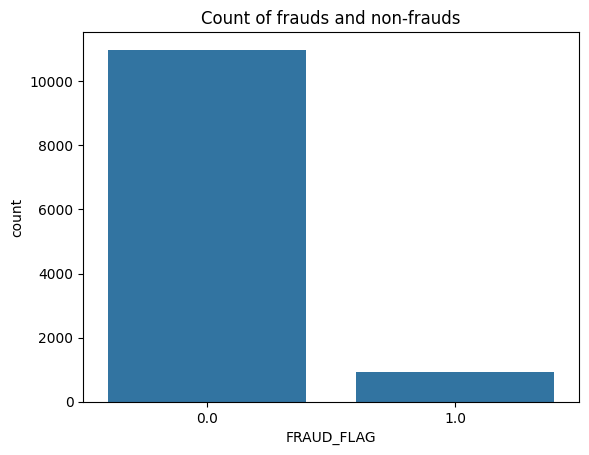

In [ ]:
# Count plot of frauds and non-frauds
fraud_count_plot = train_df.groupBy("FRAUD_FLAG").count().toPandas()
sns.barplot(x="FRAUD_FLAG", y="count", data=fraud_count_plot)
plt.title("Count of frauds and non-frauds")
plt.show()

groupBy("FRAUD_FLAG").count(): Similar to the previous explanation, this part groups the DataFrame by the "FRAUD_FLAG" column and counts the occurrences of each unique value, resulting in a DataFrame with columns "FRAUD_FLAG" and "count".

.toPandas(): Converts the result to a Pandas DataFrame. This step is necessary for using Seaborn, as it works well with Pandas DataFrames.

The landscape of our dataset reveals a significant class imbalance, a common challenge in fraud detection scenarios. In such cases, the choice of evaluation metrics plays a crucial role in capturing the model's true performance.

Given our circumstances, the prime metrics under consideration include precision, recall, F1-score The selection of the ultimate metric hinges on the unique line of business needs. In our case, the F1-score takes center stage. The F1-score harmoniously blends precision and recall, aligning with our goal of comprehensive fraud detection.

In [ ]:
# Drop columns SESSION_ID and TRANSACTION_ID
columns_to_drop = ["SESSION_ID", "TRANSACTION_ID"]
train_df = train_df.drop(*columns_to_drop)
test_df = test_df.drop(*columns_to_drop)

In [ ]:
# Drop column BROWSER_VERSION
train_df = train_df.drop("BROWSER_VERSION")
test_df = test_df.drop("BROWSER_VERSION")

In [ ]:
duplicates_before = train_df.count()

# Drop duplicate rows
train_df_no_duplicates = train_df.dropDuplicates()

# Count the number of duplicate rows after dropping
duplicates_after = train_df_no_duplicates.count()

# Calculate the number of duplicates
duplicates_count = duplicates_before - duplicates_after

print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


In [ ]:
train_df.printSchema()

root
 |-- EVENT_DATETIME: timestamp (nullable = true)
 |-- FRAUD_FLAG: double (nullable = true)
 |-- AVAIL_CRDT: double (nullable = true)
 |-- AMOUNT: double (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- CARD_NOT_PRESENT: integer (nullable = true)
 |-- FLAG_LX: integer (nullable = true)
 |-- FLAG_ATM: integer (nullable = true)
 |-- FLAG_AUTO: integer (nullable = true)
 |-- FLAG_CASH: integer (nullable = true)
 |-- FLAG_APPAREL: integer (nullable = true)
 |-- FLAG_DEAL: integer (nullable = true)
 |-- FLAG_RECREA: integer (nullable = true)
 |-- FLAG_ENTERTAINMENT: integer (nullable = true)
 |-- FLAG_GIFT_CARD: integer (nullable = true)
 |-- FLAG_FASTFOOD: integer (nullable = true)
 |-- FLAG_GAS: integer (nullable = true)
 |-- FLAG_HIGH_AMT: integer (nullable = true)
 |-- FLAG_HIGH_RECREA: integer (nullable = true)
 |-- FLAG_INTERNET: integer (nullable = true)
 |-- FLAG_INTERNATIONAL: integer (nullable = true)
 |-- FLAG_FASHION: integer (nullable = true)
 |-- FLAG_LOW

In [ ]:
# Flag columns
flag_columns = [col for col in train_df.columns if col.lower().startswith("flag")]
print("number of flags:", len(flag_columns))
print()
print("name of flags")
print(flag_columns)
print()

# Categorize columns
lx_columns = [col for col in train_df.columns if "lx" in col.lower()]
atm_columns = [col for col in train_df.columns if "atm" in col.lower()]
auto_columns = [col for col in train_df.columns if "auto" in col.lower()]
cash_columns = [col for col in train_df.columns if "cash" in col.lower()]
apparel_columns = [col for col in train_df.columns if "apparel" in col.lower()]
deal_columns = [col for col in train_df.columns if "deal" in col.lower()]

entertainment_columns = [col for col in train_df.columns if "entertainment" in col.lower()]
gift_card_columns = [col for col in train_df.columns if "gift_card" in col.lower()]
fastfood_columns = [col for col in train_df.columns if "fast" in col.lower()]
gas_columns = [col for col in train_df.columns if "gas" in col.lower()]
high_amt_columns = [col for col in train_df.columns if "high_amt" in col.lower()]

high_recrea_columns = [col for col in train_df.columns if "high_recrea" in col.lower()]
temp = [col for col in train_df.columns if "recrea" in col.lower()]
recrea_columns = [col for col in temp if col not in high_recrea_columns]

internet_columns = [col for col in train_df.columns if "internet" in col.lower()]
international_columns = [col for col in train_df.columns if "international" in col.lower()]
fashion_columns = [col for col in train_df.columns if "fashion" in col.lower()]
low_amt_columns = [col for col in train_df.columns if "low_amt" in col.lower()]
manual_columns = [col for col in train_df.columns if "manual" in col.lower()]
elctrncs_columns = [col for col in train_df.columns if "elctrncs" in col.lower()]
swipe_columns = [col for col in train_df.columns if "swipe" in col.lower()]
health_columns = [col for col in train_df.columns if "health" in col.lower()]

weekend_columns = [col for col in train_df.columns if "weekend" in col.lower()]
partial_columns = [col for col in train_df.columns if "partial" in col.lower()]

print("number of columns in train_df:", len(train_df.columns))
print("number columns in categories:", len(lx_columns) + len(atm_columns) + len(auto_columns) + len(cash_columns) + len(apparel_columns) + len(deal_columns)\
      + len(recrea_columns) + len(entertainment_columns) + len(gift_card_columns) + len(fastfood_columns) + len(gas_columns) + len(high_amt_columns)\
      + len(high_recrea_columns) + len(internet_columns) + len(international_columns) + len(fashion_columns) + len(low_amt_columns)\
      + len(manual_columns) + len(elctrncs_columns) + len(swipe_columns) + len(health_columns) + len(weekend_columns) + len(partial_columns))

other_cols = [col for col in train_df.columns if col not in lx_columns + atm_columns + auto_columns + cash_columns + apparel_columns
              + deal_columns + recrea_columns + entertainment_columns + gift_card_columns + fastfood_columns + gas_columns + high_amt_columns\
             + high_recrea_columns + internet_columns + international_columns + fashion_columns + low_amt_columns + manual_columns + elctrncs_columns\
             + swipe_columns + health_columns + weekend_columns + partial_columns]

print("length of other_cols:", len(other_cols))
print()
print("list of columns in other_columns:")
print(other_cols)

number of flags: 21

name of flags
['FLAG_LX', 'FLAG_ATM', 'FLAG_AUTO', 'FLAG_CASH', 'FLAG_APPAREL', 'FLAG_DEAL', 'FLAG_RECREA', 'FLAG_ENTERTAINMENT', 'FLAG_GIFT_CARD', 'FLAG_FASTFOOD', 'FLAG_GAS', 'FLAG_HIGH_AMT', 'FLAG_HIGH_RECREA', 'FLAG_INTERNET', 'FLAG_INTERNATIONAL', 'FLAG_FASHION', 'FLAG_LOW_AMT', 'FLAG_MANUAL_ENTRY', 'FLAG_ELCTRNCS', 'FLAG_SWIPE', 'FLAG_HEALTH']

number of columns in train_df: 154
number columns in categories: 138
length of other_cols: 16

list of columns in other_columns:
['EVENT_DATETIME', 'FRAUD_FLAG', 'AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT', 'CARD_NOT_PRESENT', 'TIMESTAMP_MIN', 'TIMESTAMP_MAX', 'PAGE_NAME', 'BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY', 'DEVICE_BRAND', 'DEVICE_MODEL', 'CITY', 'TIME_SPENT']


Flag Columns:

Flags are identified by checking if the column names start with "flag."
The code prints the number of flag columns and their names.
Categorized Columns:

Columns are categorized into different groups based on keywords present in their names.
Categories include 'lx', 'atm', 'auto', 'cash', 'apparel', 'deal', 'recrea', 'entertainment', 'gift_card', 'fastfood', 'gas', 'high_amt', 'high_recrea', 'internet', 'international', 'fashion', 'low_amt', 'manual', 'elctrncs', 'swipe', 'health', 'weekend', 'partial'.
The code prints the number of columns in each category.
Other Columns:

Columns that do not fall into any of the specified categories are considered as 'other_cols.'
The code prints the length of 'other_cols' and lists the column names in this category.

In [ ]:
var_list = []
num_of_frauds = []
percentage_of_fraud = []
num_of_non_frauds = []
percentage_of_non_fraud = []

for col_name in flag_columns:
    var_list.append(col_name)

    fraud_flag_1 = train_df.filter(col("FRAUD_FLAG") == 1)
    fraud_flag_0 = train_df.filter(col("FRAUD_FLAG") == 0)

    num_of_frauds.append(fraud_flag_1.agg({col_name: "sum"}).first()[0])
    percentage_of_fraud.append(round(num_of_frauds[-1] / fraud_flag_1.count() * 100, 2))

    num_of_non_frauds.append(fraud_flag_0.agg({col_name: "sum"}).first()[0])
    percentage_of_non_fraud.append(round(num_of_non_frauds[-1] / fraud_flag_0.count() * 100, 2))

fraud_based_on_flag_cols = spark.createDataFrame(
    list(zip(var_list, num_of_frauds, percentage_of_fraud, num_of_non_frauds, percentage_of_non_fraud)),
    schema=["Column", "# of frauds", "% of fraud", "# of non_frauds", "% of non_fraud"]
)

fraud_based_on_flag_cols.show()

+------------------+-----------+----------+---------------+--------------+
|            Column|# of frauds|% of fraud|# of non_frauds|% of non_fraud|
+------------------+-----------+----------+---------------+--------------+
|           FLAG_LX|         39|      4.25|            717|          6.53|
|          FLAG_ATM|          0|       0.0|              0|           0.0|
|         FLAG_AUTO|          1|      0.11|             62|          0.56|
|         FLAG_CASH|          0|       0.0|              0|           0.0|
|      FLAG_APPAREL|        287|     31.26|           2838|         25.84|
|         FLAG_DEAL|         19|      2.07|             52|          0.47|
|       FLAG_RECREA|          0|       0.0|              0|           0.0|
|FLAG_ENTERTAINMENT|        115|     12.53|           1066|           9.7|
|    FLAG_GIFT_CARD|        270|     29.41|            464|          4.22|
|     FLAG_FASTFOOD|          0|       0.0|              0|           0.0|
|          FLAG_GAS|     

Initialization:

Initialize lists (var_list, num_of_frauds, percentage_of_fraud, num_of_non_frauds, percentage_of_non_fraud) to store information about each flag column.
Loop Through Flag Columns:

Iterate over each column name in the flag_columns list.
Fraud and Non-Fraud Count:

For each flag column, filter the train_df DataFrame into two subsets: one for fraud cases (fraud_flag_1) and one for non-fraud cases (fraud_flag_0).
Calculate the number of frauds and non-frauds for each flag column.
Calculate Percentages:

Calculate the percentage of frauds and non-frauds for each flag column based on the counts obtained in the previous step.
Create Result DataFrame:

Use the collected information to create a new DataFrame (fraud_based_on_flag_cols) with columns: "Column," "# of frauds," "% of fraud," "# of non_frauds," "% of non_fraud."
Display Result:

Show the resulting DataFrame, which provides a summary of fraud and non-fraud counts and percentages for each flag column.

Here's the scoop: some columns like "FLAG_ATM," "FLAG_AUTO," and the gang, don't seem to hang out much with frauds. They're kind of like different cliques in the data world.

Then there's the enigmatic "FLAG_INTERNET" - it's like a magnet for frauds, with a full 100% of its encounters being fishy.

In [ ]:
selected_columns = ['AVAIL_CRDT', 'AMOUNT', 'CREDIT_LIMIT']

# Calculate the correlation matrix
correlation_matrix = train_df.select([col(c).cast("double") for c in selected_columns]).toPandas().corr()

# Show the correlation matrix
print(correlation_matrix)

              AVAIL_CRDT    AMOUNT  CREDIT_LIMIT
AVAIL_CRDT      1.000000  0.055768      0.840051
AMOUNT          0.055768  1.000000      0.075691
CREDIT_LIMIT    0.840051  0.075691      1.000000


It's decision time, and we're navigating the landscape of credit-related columns. Here's the scoop: there is a strong association between credit limit and accessible credit.

1. WITHOUT OVERSAMPLING

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Load data
train_df = spark.read.csv("/content/drive/MyDrive/train_after_EDA.csv", header=True, inferSchema=True)
test_df = spark.read.csv("/content/drive/MyDrive/test_after_EDA.csv", header=True, inferSchema=True)



In [ ]:
# Define features and label
feature_cols = [col for col in train_df.columns if col != "FRAUD_FLAG"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Split data
train_data, test_data = train_df.randomSplit([0.7, 0.3], seed=42)

# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol="FRAUD_FLAG")  # Specify the label column




Define Features and Label:

feature_cols: Extracts all columns from the train_df DataFrame except for the "FRAUD_FLAG" column, considering them as features.
assembler: Uses the VectorAssembler to transform the DataFrame by combining the selected feature columns into a single vector column named "features."
train_df and test_df are updated to include the new "features" column.
Split Data:

Splits the data into training and testing sets using the randomSplit method. 70% of the data is used for training (train_data), and 30% is used for testing (test_data). A seed value of 42 is set for reproducibility.
Define Decision Tree Classifier:

dt: Creates an instance of the Decision Tree Classifier from the pyspark.ml.classification module.
The classifier is configured with the "featuresCol" parameter set to "features" (the assembled feature vector) and the "labelCol" parameter set to "FRAUD_FLAG" (the target variable).

In [ ]:
# Create a pipeline
pipeline = Pipeline(stages=[dt])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)



Create a Pipeline:

pipeline: Initializes a machine learning pipeline using Pipeline from pyspark.ml. The pipeline is configured with a single stage, which is the Decision Tree Classifier (dt) defined earlier.
Fit the Model:

model: Fits the machine learning model on the training data using the fit method of the pipeline. This involves training the Decision Tree Classifier on the features and labels from the training set.
Make Predictions:

predictions: Applies the trained model to the test data using the transform method of the pipeline. This step generates predictions for the test set based on the features.

<ipython-input-91-4719508693b0>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(conf_matrix.pivot("FRAUD_FLAG", "prediction", "count"), annot=True, fmt="d", cmap="Blues")


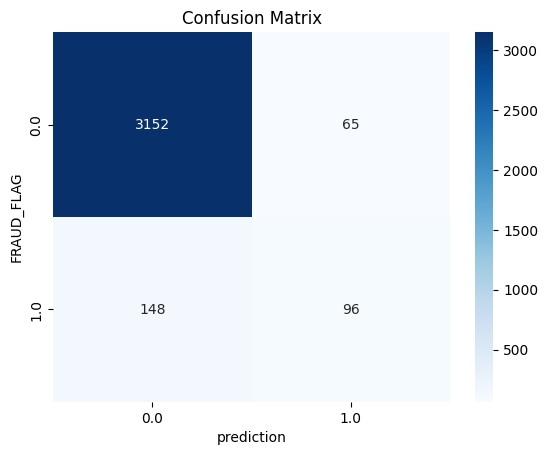

Accuracy: 93.85%


In [ ]:
# Display confusion matrix
conf_matrix = predictions.groupBy("FRAUD_FLAG", "prediction").count().toPandas()
sns.heatmap(conf_matrix.pivot("FRAUD_FLAG", "prediction", "count"), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="FRAUD_FLAG", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2%}".format(accuracy))


# Close the Spark session
spark.stop()

with oversampling

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from imblearn.over_sampling import SMOTE
from pyspark.ml.linalg import DenseVector
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

# Initialize Spark session
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

# Load data
train_df = spark.read.csv("/content/drive/MyDrive/train_after_EDA.csv", header=True, inferSchema=True)
test_df = spark.read.csv("/content/drive/MyDrive/test_after_EDA.csv", header=True, inferSchema=True)

# Assuming 'FRAUD_FLAG' is the target variable
target_col = 'FRAUD_FLAG'




This code snippet initializes a Spark session, loads data from CSV files using Spark, and defines some necessary imports and variables for fraud detection using a Decision Tree Classifier and SMOTE (Synthetic Minority Over-sampling Technique) for handling imbalanced data. Here's a short explanation:

Imports:

Various necessary libraries are imported, including Spark MLlib components (VectorAssembler, DecisionTreeClassifier, MulticlassClassificationEvaluator, Pipeline), imbalanced learning library (SMOTE), and other relevant Spark and Python libraries.
Initialize Spark Session:

SparkSession.builder.appName("FraudDetection").getOrCreate(): Initiates a Spark session named "FraudDetection."
Load Data:

Reads CSV files containing the training and test datasets into Spark DataFrames (train_df and test_df).
Target Variable:

target_col: Specifies the name of the target variable, assumed to be "FRAUD_FLAG."

In [ ]:
# Define features and label
feature_cols = [col for col in train_df.columns if col != target_col]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Extract features and labels
X_train = train_df.select("features").rdd.map(lambda x: DenseVector(x[0].toArray())).collect()
y_train = train_df.select(target_col).rdd.map(lambda x: x[0]).collect()



his code snippet involves defining features and labels, using a VectorAssembler to create feature vectors, and extracting features and labels from the Spark DataFrame. Here's a brief explanation:

Define Features and Label:

feature_cols: Identifies the feature columns by excluding the target variable column (target_col).
assembler: Utilizes the VectorAssembler to transform the DataFrame by combining the selected feature columns into a single vector column named "features."
train_df and test_df are updated to include the new "features" column.
Extract Features and Labels:

X_train: Extracts the feature vectors from the "features" column in the train_df DataFrame. The feature vectors are collected into a list of DenseVector objects.
y_train: Extracts the target variable values (labels) from the train_df DataFrame. The labels are collected into a list.

In [ ]:
# SMOTE-like resampling (simple oversampling)
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create a new Spark DataFrame from the resampled data
resampled_data = [(DenseVector(features), label) for features, label in zip(X_train_resampled, y_train_resampled)]
resampled_df = spark.createDataFrame(resampled_data, ["features", target_col])

# Split data
train_data, test_data = resampled_df.randomSplit([0.7, 0.3], seed=42)

# Define the Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features", labelCol=target_col)



SMOTE Resampling:

smote = SMOTE(sampling_strategy=1.0, random_state=42): Initializes the SMOTE object with a sampling strategy of 1.0, indicating that the number of samples in the minority class (fraud) should be equal to the number of samples in the majority class (non-fraud).
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train): Applies SMOTE to oversample the minority class in the training data, resulting in resampled feature vectors (X_train_resampled) and labels (y_train_resampled).
Create Resampled Spark DataFrame:

resampled_data: Creates a list of tuples, where each tuple contains a DenseVector of features and the corresponding label from the resampled data.
resampled_df: Uses spark.createDataFrame to create a new Spark DataFrame (resampled_df) from the resampled data, with columns "features" and the target variable column (target_col).
Split Resampled Data:

train_data, test_data = resampled_df.randomSplit([0.7, 0.3], seed=42): Splits the resampled data into training and testing sets using a 70-30 split ratio. A seed of 42 is set for reproducibility.
Define Decision Tree Classifier:

dt = DecisionTreeClassifier(featuresCol="features", labelCol=target_col): Initializes the Decision Tree Classifier with the feature and label columns specified.

In [ ]:
# Create a pipeline
pipeline = Pipeline(stages=[dt])

# Fit the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)



<ipython-input-97-6c6c2d09e7f9>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(conf_matrix.pivot(target_col, "prediction", "count"), annot=True, fmt="d", cmap="Blues")


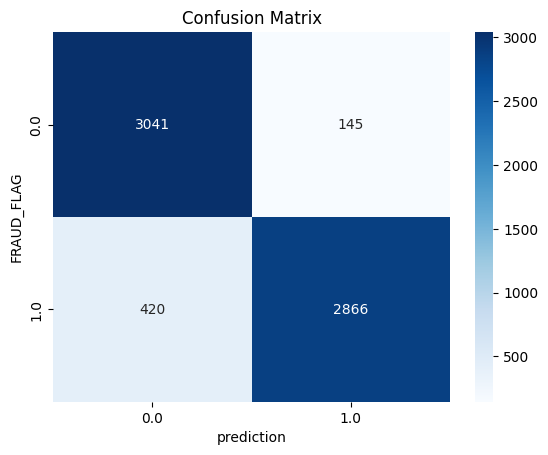

Accuracy: 91.27%


In [ ]:
# Display confusion matrix
conf_matrix = predictions.groupBy(target_col, "prediction").count().toPandas()
sns.heatmap(conf_matrix.pivot(target_col, "prediction", "count"), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol=target_col, predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2%}".format(accuracy))

# Close the Spark session
spark.stop()